<a href="https://colab.research.google.com/github/ndtu1511/HousePricePrediction/blob/master/Nguyen_Duc_Tu_House_Prices_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##References:

https://www.kaggle.com/serigne/stacked-regressions-top-4-on-leaderboard

https://www.kaggle.com/jack89roberts/top-7-using-elasticnet-with-interactions

https://www.kaggle.com/itslek/blend-stack-lr-gb-0-10649-house-prices-v57

https://www.kaggle.com/firstbloody/an-uncomplicated-model-top-2-or-top-1

# Load Data

In [0]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from sklearn.linear_model import Ridge,ElasticNet, Lasso


In [0]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
print ("Train shape: ",train.shape)
test_ID = test['Id']
train_ID = train['Id']
train.drop("Id", axis = 1, inplace = True)
test.drop("Id", axis = 1, inplace = True)
all_data = pd.concat([train,test],sort =True)
all_data.drop(['SalePrice'], axis=1, inplace=True)
print ("All data shape: ",all_data.shape)

Train shape:  (1460, 81)
All data shape:  (2919, 79)


In [0]:
all_data.head()

,1stFlrSF,2ndFlrSF,3SsnPorch,Alley,BedroomAbvGr,BldgType,BsmtCond,BsmtExposure,BsmtFinSF1,BsmtFinSF2,BsmtFinType1,BsmtFinType2,BsmtFullBath,BsmtHalfBath,BsmtQual,BsmtUnfSF,CentralAir,Condition1,Condition2,Electrical,EnclosedPorch,ExterCond,ExterQual,Exterior1st,Exterior2nd,Fence,FireplaceQu,Fireplaces,Foundation,FullBath,Functional,GarageArea,GarageCars,GarageCond,GarageFinish,GarageQual,GarageType,GarageYrBlt,GrLivArea,HalfBath,Heating,HeatingQC,HouseStyle,KitchenAbvGr,KitchenQual,LandContour,LandSlope,LotArea,LotConfig,LotFrontage,LotShape,LowQualFinSF,MSSubClass,MSZoning,MasVnrArea,MasVnrType,MiscFeature,MiscVal,MoSold,Neighborhood,OpenPorchSF,OverallCond,OverallQual,PavedDrive,PoolArea,PoolQC,RoofMatl,RoofStyle,SaleCondition,SaleType,ScreenPorch,Street,TotRmsAbvGrd,TotalBsmtSF,Utilities,WoodDeckSF,YearBuilt,YearRemodAdd,YrSold
0,856,854,0,NaN,3,1Fam,TA,No,706.0,0.0,GLQ,Unf,1.0,0.0,Gd,150.0,Y,Norm,Norm,SBrkr,0,TA,Gd,VinylSd,VinylSd,NaN,NaN,0,PConc,2,Typ,548.0,2.0,TA,RFn,TA,Attchd,2003.0,1710,1,GasA,Ex,2Story,1,Gd,Lvl,Gtl,8450,Inside,65.0,Reg,0,60,RL,196.0,BrkFace,NaN,0,2,CollgCr,61,5,7,Y,0,NaN,CompShg,Gable,Normal,WD,0,Pave,8,856.0,AllPub,0,2003,2003,2008
1,1262,0,0,NaN,3,1Fam,TA,Gd,978.0,0.0,ALQ,Unf,0.0,1.0,Gd,284.0,Y,Feedr,Norm,SBrkr,0,TA,TA,MetalSd,MetalSd,NaN,TA,1,CBlock,2,Typ,460.0,2.0,TA,RFn,TA,Attchd,1976.0,1262,0,GasA,Ex,1Story,1,TA,Lvl,Gtl,9600,FR2,80.0,Reg,0,20,RL,0.0,None,NaN,0,5,Veenker,0,8,6,Y,0,NaN,CompShg,Gable,Normal,WD,0,Pave,6,1262.0,AllPub,298,1976,1976,2007
2,920,866,0,NaN,3,1Fam,TA,Mn,486.0,0.0,GLQ,Unf,1.0,0.0,Gd,434.0,Y,Norm,Norm,SBrkr,0,TA,Gd,VinylSd,VinylSd,NaN,TA,1,PConc,2,Typ,608.0,2.0,TA,RFn,TA,Attchd,2001.0,1786,1,GasA,Ex,2Story,1,Gd,Lvl,Gtl,11250,Inside,68.0,IR1,0,60,RL,162.0,BrkFace,NaN,0,9,CollgCr,42,5,7,Y,0,NaN,CompShg,Gable,Normal,WD,0,Pave,6,920.0,AllPub,0,2001,2002,2008
3,961,756,0,NaN,3,1Fam,Gd,No,216.0,0.0,ALQ,Unf,1.0,0.0,TA,540.0,Y,Norm,Norm,SBrkr,272,TA,TA,Wd Sdng,Wd Shng,NaN,Gd,1,BrkTil,1,Typ,642.0,3.0,TA,Unf,TA,Detchd,1998.0,1717,0,GasA,Gd,2Story,1,Gd,Lvl,Gtl,9550,Corner,60.0,IR1,0,70,RL,0.0,None,NaN,0,2,Crawfor,35,5,7,Y,0,NaN,CompShg,Gable,Abnorml,WD,0,Pave,7,756.0,AllPub,0,1915,1970,2006
4,1145,1053,0,NaN,4,1Fam,TA,Av,655.0,0.0,GLQ,Unf,1.0,0.0,Gd,490.0,Y,Norm,Norm,SBrkr,0,TA,Gd,VinylSd,VinylSd,NaN,TA,1,PConc,2,Typ,836.0,3.0,TA,RFn,TA,Attchd,2000.0,2198,1,GasA,Ex,2Story,1,Gd,Lvl,Gtl,14260,FR2,84.0,IR1,0,60,RL,350.0,BrkFace,NaN,0,12,NoRidge,84,5,8,Y,0,NaN,CompShg,Gable,Normal,WD,0,Pave,9,1145.0,AllPub,192,2000,2000,2008


#EDA

##Analysing SalePrice


Check distribution of SalePrice

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64


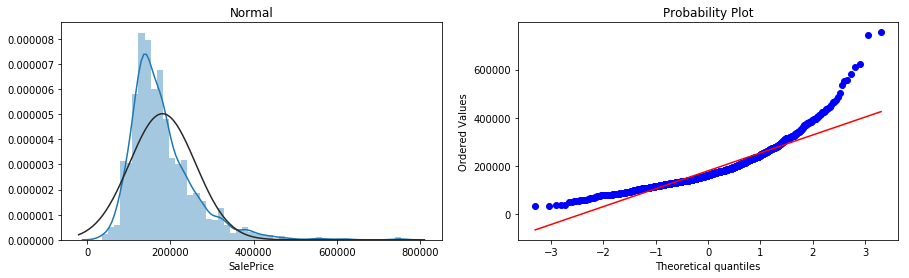

In [0]:

print(train['SalePrice'].describe())
f, (ax1, ax2) = plt.subplots(1,2)
f.set_figwidth(15, forward=True)
ax1.set_title('Normal')
sns.distplot(train['SalePrice'],fit=stats.norm,ax = ax1)
res = stats.probplot(train['SalePrice'], plot=ax2)

Tranform

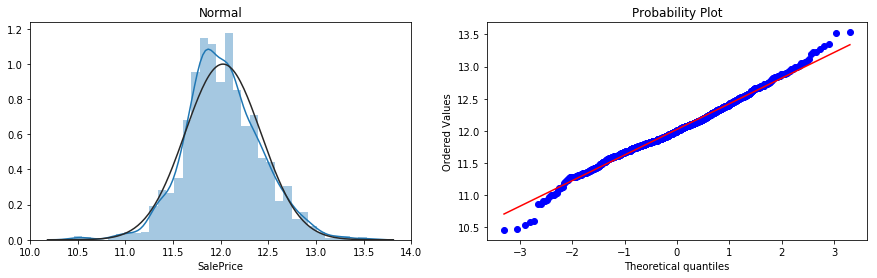

In [0]:
train["SalePrice"] = np.log1p(train["SalePrice"])
f, (ax1, ax2) = plt.subplots(1,2)
f.set_figwidth(15, forward=True)
ax1.set_title('Normal')
sns.distplot(train['SalePrice'],fit=stats.norm,ax = ax1)
res = stats.probplot(train['SalePrice'], plot=ax2)

##Handle NaN Values

Transforming some numerical variables that are really categorical

In [0]:
all_data['MSSubClass'] = all_data['MSSubClass'].apply(str)
all_data['MoSold'] = all_data['MoSold'].astype(str)


In [0]:
total = all_data.isnull().sum().sort_values(ascending=False)
percent = (all_data.isnull().sum() / all_data.isnull().count()).sort_values(ascending=False)
types = all_data[total.index].dtypes
missing_data = pd.concat([total, percent, types], axis=1, keys=['Total', 'Percent', 'Type'])
missing_data[missing_data['Total']>0]

,Total,Percent,Type
PoolQC,2909,0.996574,object
MiscFeature,2814,0.964029,object
Alley,2721,0.932169,object
Fence,2348,0.804385,object
FireplaceQu,1420,0.486468,object
LotFrontage,486,0.166495,float64
GarageFinish,159,0.054471,object
GarageQual,159,0.054471,object
GarageYrBlt,159,0.054471,float64
GarageCond,159,0.054471,object


In [0]:
all_data['Utilities'].value_counts()

AllPub    2916
NoSeWa       1
Name: Utilities, dtype: int64

##Fill Missing Data

In [0]:
for col in ('PoolQC','MiscFeature','Alley','Fence','FireplaceQu'):
    all_data[col] = all_data[col].fillna('None')
    
for col in ['GarageType', 'GarageFinish', 'GarageQual', 'GarageCond']:
    all_data[col] = all_data[col].fillna('None')
    
for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
    all_data[col] = all_data[col].fillna('None')
    
for col in ('GarageArea', 'GarageCars'):
    all_data[col] = all_data[col].fillna(0)
all_data.loc[all_data.GarageYrBlt.isnull(),'GarageYrBlt'] = all_data.loc[all_data.GarageYrBlt.isnull(),'YearBuilt']
    
for col in ('BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath'):
    all_data[col] = all_data[col].fillna(0)
    
all_data["MasVnrType"] = all_data["MasVnrType"].fillna("None")
all_data["MasVnrArea"] = all_data["MasVnrArea"].fillna(0)

all_data['MSZoning'] = all_data.groupby('MSSubClass')['MSZoning'].transform(lambda x: x.fillna(x.mode()[0]))

all_data["Functional"] = all_data["Functional"].fillna("Typ")

all_data['Electrical'] = all_data['Electrical'].fillna(all_data['Electrical'].mode()[0])
all_data['KitchenQual'] = all_data['KitchenQual'].fillna(all_data['KitchenQual'].mode()[0])
all_data['Exterior1st'] = all_data['Exterior1st'].fillna(all_data['Exterior1st'].mode()[0])
all_data['Exterior2nd'] = all_data['Exterior2nd'].fillna(all_data['Exterior2nd'].mode()[0])
all_data['SaleType'] = all_data['SaleType'].fillna(all_data['SaleType'].mode()[0])

all_data = all_data.drop(['Utilities'], axis=1)

## Fill LotFrontage Missing Values By Linear Regression

In [0]:
def scale_minmax(col):
    return (col-col.min())/(col.max()-col.min())

In [0]:
data_predic_lotfront = all_data.copy()
data_predic_lotfront = pd.get_dummies(data_predic_lotfront)
for col in data_predic_lotfront.drop('LotFrontage',axis=1).columns:
    data_predic_lotfront[col] = scale_minmax(data_predic_lotfront[col])
lotfront_train = data_predic_lotfront.dropna()
lotfront_train_X = lotfront_train.drop('LotFrontage',axis=1)
lotfront_train_y = lotfront_train.LotFrontage
lr = Ridge()
lr.fit(lotfront_train_X,lotfront_train_y)

nan_frontage = all_data.LotFrontage.isnull()
X = data_predic_lotfront[nan_frontage].drop('LotFrontage',axis=1)
y = lr.predict(X)
all_data.loc[nan_frontage,'LotFrontage'] = y

check missing again

In [0]:
total = all_data.isnull().sum().sort_values(ascending=False)
percent = (all_data.isnull().sum() / all_data.isnull().count()).sort_values(ascending=False)
types = all_data[total.index].dtypes
missing_data = pd.concat([total, percent, types], axis=1, keys=['Total', 'Percent', 'Type'])
missing_data[missing_data['Total']>0]

,Total,Percent,Type


##Categorical Features With Meaningful Ordering

Label Encoding some categorical variables that may contain information in their ordering set

In [0]:
cols_ExGd = ['BsmtQual','BsmtCond','FireplaceQu','GarageQual','GarageCond','PoolQC']
dict_ExGd = {'Ex':5,'Gd':4,'TA':3,'Fa':2,'Po':1,'None':0}
for col in cols_ExGd:
    all_data[col].replace(dict_ExGd, inplace=True)

cols_ExGd = ['ExterCond','HeatingQC']
dict_ExGd = {'Ex':4,'Gd':3,'TA':2,'Fa':1,'Po':0}
for col in cols_ExGd:
    all_data[col].replace(dict_ExGd, inplace=True)
    
cols_ExGd = ['ExterQual','KitchenQual']
dict_ExGd = {'Ex':4,'Gd':3,'TA':2,'Fa':1}
for col in cols_ExGd:
    all_data[col].replace(dict_ExGd, inplace=True)  
    
all_data['BsmtExposure'].replace({'Gd':4,'Av':3,'Mn':2,'No':1,'None':0}, inplace=True)

all_data['CentralAir'].replace({'Y':1,'N':0}, inplace=True)

all_data['GarageFinish'].replace({'Fin':3,'RFn':2,'Unf':1,'None':0}, inplace=True)

all_data['LotShape'].replace({'Reg':3,'IR1':2,'IR2':1,'IR3':0}, inplace=True)

all_data['LandSlope'].replace({'Gtl':2,'Mod':1,'Sev':0}, inplace=True)

cols_fin = ['BsmtFinType1','BsmtFinType2']
fin_type = {'GLQ':6,'ALQ':5,'BLQ':4,'Rec':3,'LwQ':2,'Unf':1,'None':0}
for col in cols_fin:
    all_data[col].replace(fin_type, inplace=True)
    
print('Shape all_data: {}'.format(all_data.shape))


Shape all_data: (2919, 78)


## Add and delete some data

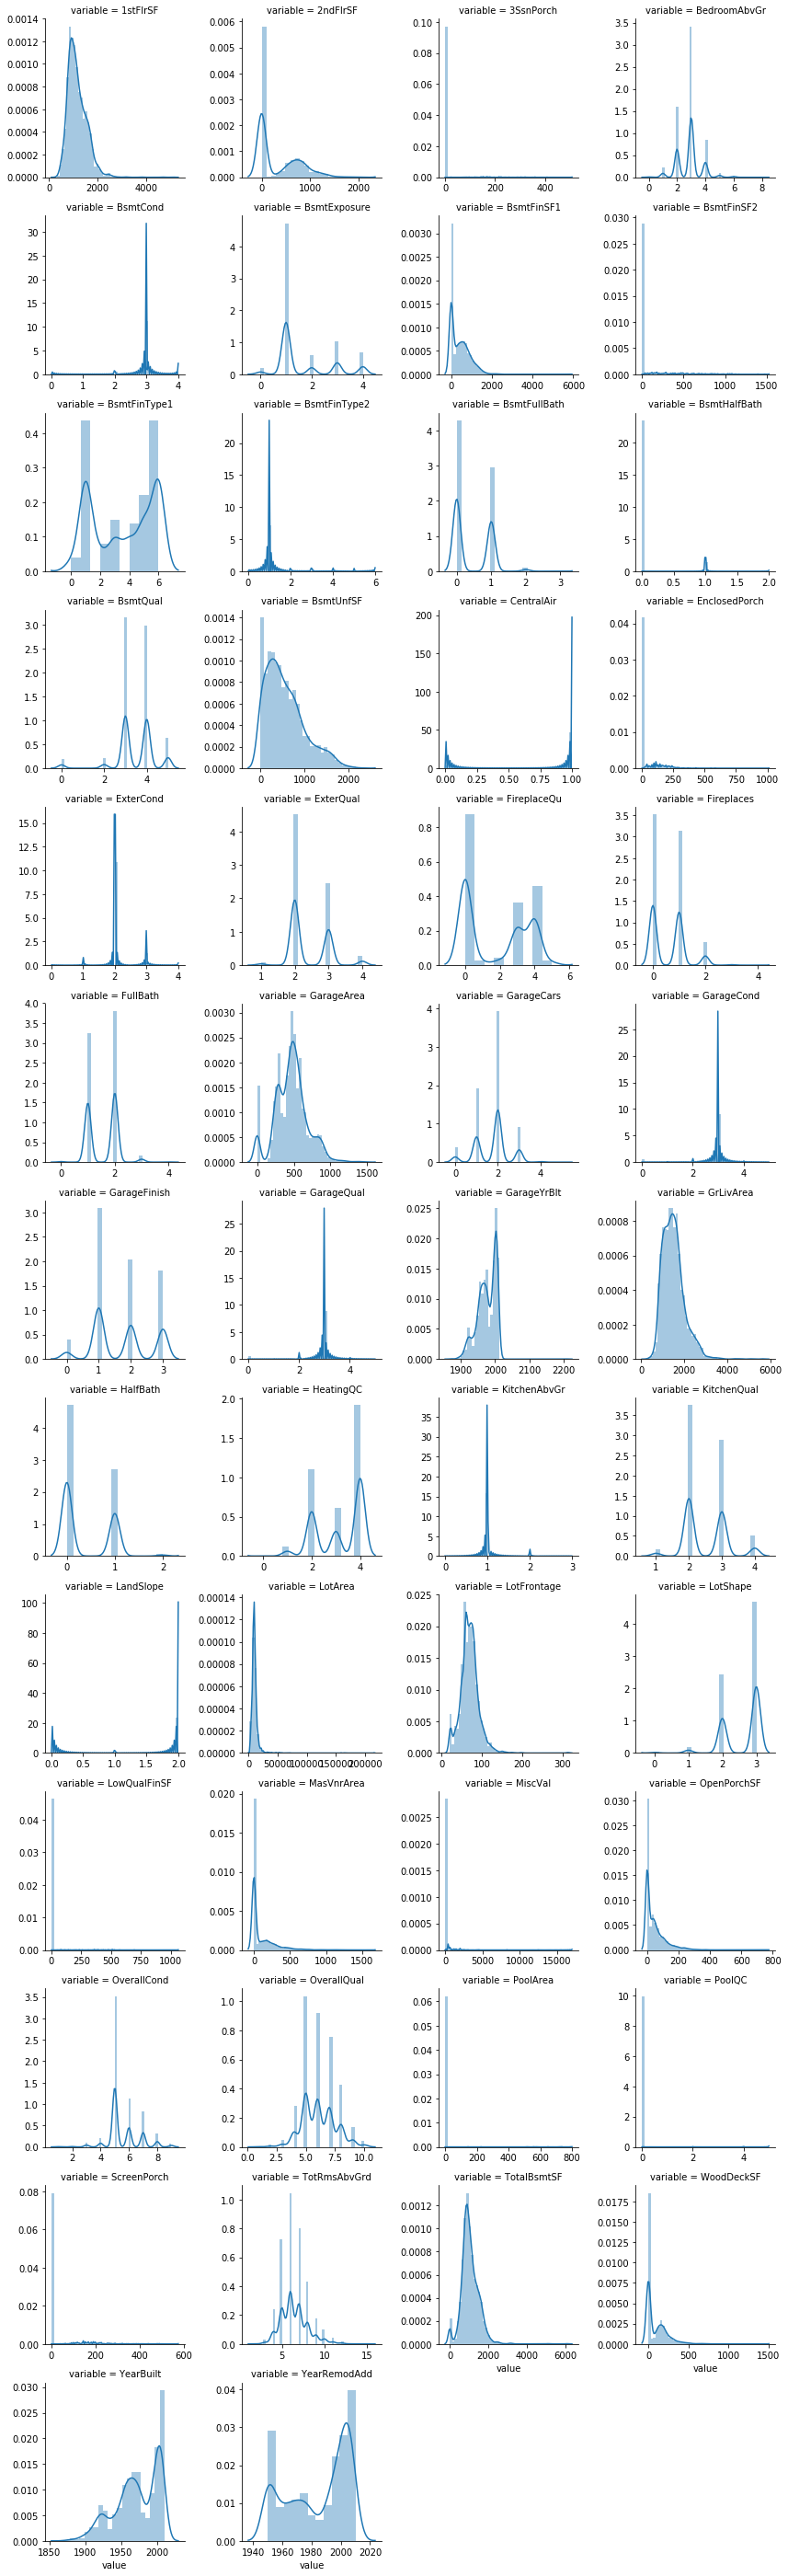

In [0]:
quantitative = [f for f in all_data.columns if all_data.dtypes[f] != 'object']
f = pd.melt(all_data, value_vars=quantitative)
grid = sns.FacetGrid(f, col='variable',  col_wrap=4, sharex=False, sharey=False)
grid = grid.map(sns.distplot, 'value')

In [0]:
all_data['TotalSF'] = all_data['TotalBsmtSF'] + all_data['1stFlrSF'] + all_data['2ndFlrSF']
all_data['YrBltAndRemod']=all_data['YearBuilt']+all_data['YearRemodAdd']

all_data['Total_sqr_footage'] = (all_data['BsmtFinSF1'] + all_data['BsmtFinSF2'] +
                                 all_data['1stFlrSF'] + all_data['2ndFlrSF'])

all_data['Total_Bathrooms'] = (all_data['FullBath'] + (0.5 * all_data['HalfBath']) +
                               all_data['BsmtFullBath'] + (0.5 * all_data['BsmtHalfBath']))

all_data['Total_porch_sf'] = (all_data['OpenPorchSF'] + all_data['3SsnPorch'] +
                              all_data['EnclosedPorch'] + all_data['ScreenPorch'] +
                              all_data['WoodDeckSF'])

dummy_cols = ['PoolArea','2ndFlrSF','GarageArea','TotalBsmtSF','Fireplaces','LowQualFinSF','MiscVal',
             'ScreenPorch','WoodDeckSF','OpenPorchSF','EnclosedPorch','MasVnrArea']
for col in dummy_cols:
  all_data['Has'+col] = all_data[col].apply(lambda x: 1 if x > 0 else 0)

delete_cols = ['PoolArea','PoolQC','3SsnPorch','BsmtHalfBath','HalfBath',
               'ScreenPorch','LowQualFinSF','EnclosedPorch',
              'Fence', 'MiscFeature', 'LandSlope','Exterior2nd','MiscVal']
all_data.drop(delete_cols,axis=1,inplace=True)

## Identify Types of Features

In [0]:
cols_numeric = [f for f in all_data.columns if all_data.dtypes[f] != 'object']

col_nunique = dict()

for col in cols_numeric:
    col_nunique[col] = all_data[col].nunique()
    
col_nunique = pd.Series(col_nunique)

cols_discrete = col_nunique[col_nunique<13].index.tolist()
cols_continuous = col_nunique[col_nunique>=13].index.tolist()
print(len(cols_numeric),'numeric columns, of which',
      len(cols_continuous),'are continuous and',
      len(cols_discrete),'are discrete.')

57 numeric columns, of which 21 are continuous and 36 are discrete.


In [0]:
cols_categ = [f for f in all_data.columns if all_data.dtypes[f] == 'object']
for col in cols_categ:
    all_data[col] = all_data[col].astype('category')
    
print(len(cols_categ),'categorical columns.')

25 categorical columns.


In [0]:
all_data[cols_numeric] = all_data[cols_numeric].apply(scale_minmax,axis=0)
all_data[cols_numeric].describe()

,1stFlrSF,2ndFlrSF,BedroomAbvGr,BsmtCond,BsmtExposure,BsmtFinSF1,BsmtFinSF2,BsmtFinType1,BsmtFinType2,BsmtFullBath,BsmtQual,BsmtUnfSF,CentralAir,ExterCond,ExterQual,FireplaceQu,Fireplaces,FullBath,GarageArea,GarageCars,GarageCond,GarageFinish,GarageQual,GarageYrBlt,GrLivArea,HeatingQC,KitchenAbvGr,KitchenQual,LotArea,LotFrontage,LotShape,MasVnrArea,OpenPorchSF,OverallCond,OverallQual,TotRmsAbvGrd,TotalBsmtSF,WoodDeckSF,YearBuilt,YearRemodAdd,TotalSF,YrBltAndRemod,Total_sqr_footage,Total_Bathrooms,Total_porch_sf,HasPoolArea,Has2ndFlrSF,HasGarageArea,HasTotalBsmtSF,HasFireplaces,HasLowQualFinSF,HasMiscVal,HasScreenPorch,HasWoodDeckSF,HasOpenPorchSF,HasEnclosedPorch,HasMasVnrArea
count,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000
mean,0.173405,0.162946,0.357528,0.729616,0.405961,0.078184,0.032481,0.590271,0.212287,0.143200,0.695512,0.239974,0.932854,0.521411,0.465570,0.353614,0.149281,0.392001,0.317683,0.353203,0.561768,0.572000,0.560192,0.311206,0.219812,0.787941,0.348179,0.503597,0.041450,0.171833,0.866621,0.063373,0.063998,0.570572,0.565452,0.342425,0.172081,0.065807,0.719658,0.571075,0.193859,0.660933,0.150922,0.203066,0.128483,0.004454,0.428571,0.945872,0.972936,0.513532,0.013703,0.035286,0.087701,0.478246,0.555327,0.157246,0.396711
std,0.082412,0.207604,0.102837,0.143737,0.267506,0.080724,0.110864,0.352309,0.159197,0.174892,0.181090,0.188181,0.250318,0.093090,0.193431,0.361324,0.161532,0.138242,0.144849,0.152439,0.142500,0.299109,0.143173,0.080717,0.095337,0.239488,0.071487,0.220720,0.036865,0.077552,0.190058,0.111784,0.091072,0.139141,0.156661,0.120721,0.072196,0.088853,0.219503,0.348239,0.070513,0.242856,0.069477,0.134807,0.112375,0.066598,0.494956,0.226309,0.162298,0.499902,0.116276,0.184534,0.282908,0.499612,0.497015,0.364095,0.489299
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.113842,0.000000,0.250000,0.750000,0.250000,0.000000,0.000000,0.166667,0.166667,0.000000,0.600000,0.094178,1.000000,0.500000,0.333333,0.000000,0.000000,0.250000,0.215054,0.200000,0.600000,0.333333,0.600000,0.258209,0.149209,0.500000,0.333333,0.333333,0.028877,0.134628,0.666667,0.000000,0.000000,0.500000,0.444444,0.230769,0.129787,0.000000,0.590580,0.250000,0.145910,0.473684,0.105278,0.083333,0.033708,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.157110,0.000000,0.375000,0.750000,0.250000,0.065202,0.000000,0.666667,0.166667,0.000000,0.800000,0.199914,1.000000,0.500000,0.333333,0.200000,0.250000,0.500000,0.322581,0.400000,0.600000,0.666667,0.600000,0.316418,0.209118,1.000000,0.333333,0.333333,0.038108,0.172104,1.000000,0.000000,0.035040,0.500000,0.555556,0.307692,0.161866,0.000000,0.731884,0.716667,0.185146,0.652632,0.138240,0.166667,0.115169,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
75%,0.221277,0.340920,0.375000,0.75000

## Box Cox Tranformation With Numeric Features

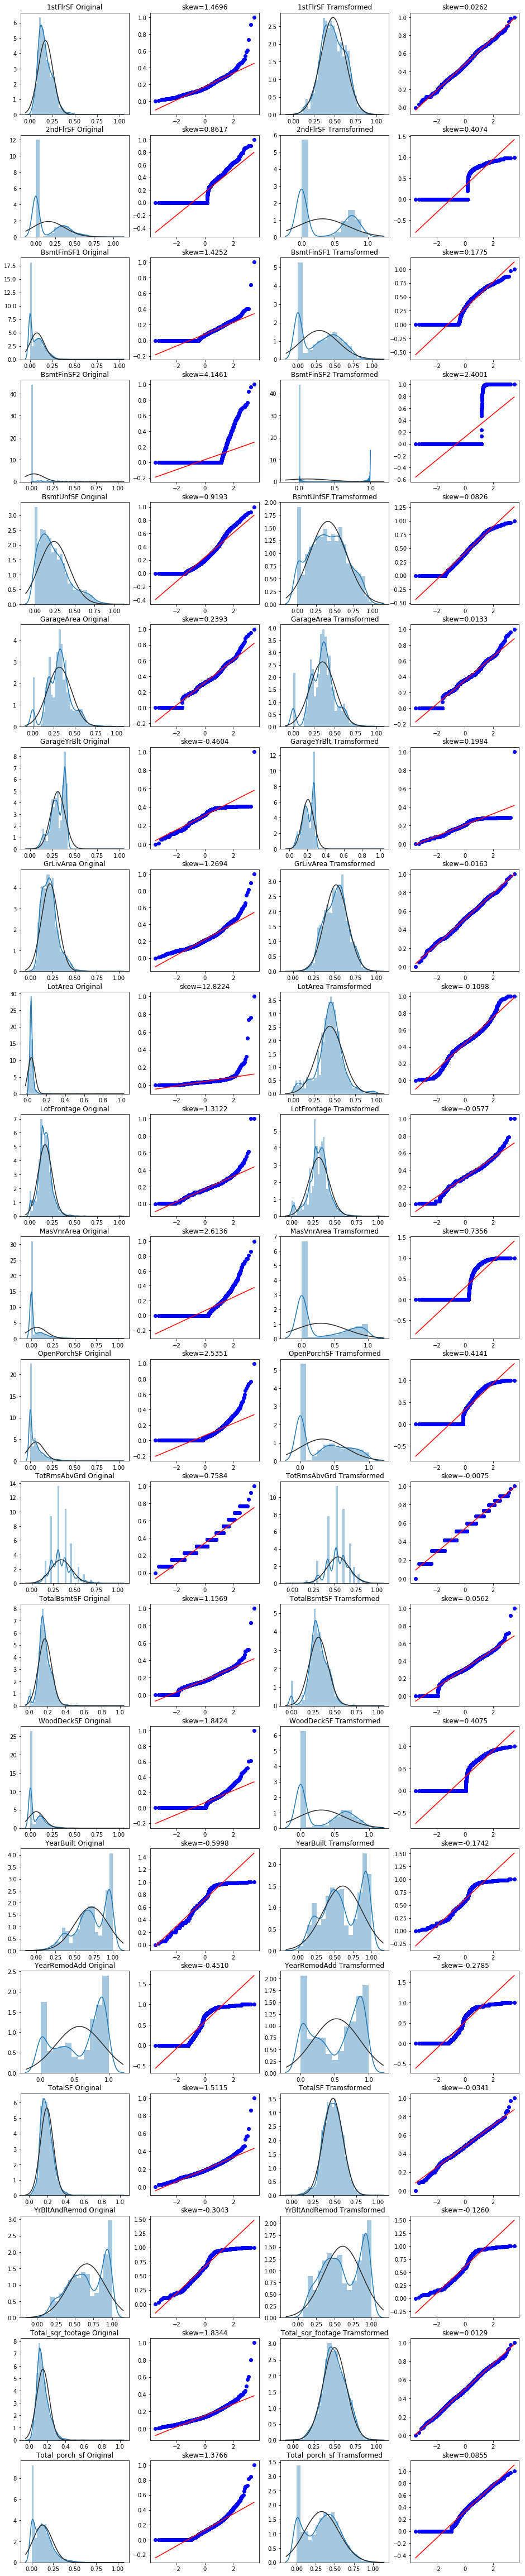

In [0]:
fcols = 4
frows = len(cols_continuous)
plt.figure(figsize=(4*fcols,4*frows))
i=0
for var in cols_continuous:
    i+=1
    plt.subplot(frows,fcols,i)
    sns.distplot(all_data[var] , fit=stats.norm);
    plt.title(var+' Original')
    plt.xlabel('')
    
    i+=1
    plt.subplot(frows,fcols,i)
    _=stats.probplot(all_data[var], plot=plt)
    plt.title('skew='+'{:.4f}'.format(stats.skew(all_data[var])))
    plt.xlabel('')
    plt.ylabel('')
      
    i+=1
    plt.subplot(frows,fcols,i)
    trans_var, _= stats.boxcox(all_data[var].dropna()+1)
    trans_var = scale_minmax(trans_var)      
    sns.distplot(trans_var , fit=stats.norm);
    plt.title(var+' Tramsformed')
    plt.xlabel('')
    
    i+=1
    plt.subplot(frows,fcols,i)
    _=stats.probplot(trans_var, plot=plt)
    plt.title('skew='+'{:.4f}'.format(stats.skew(trans_var)))
    plt.xlabel('')
    plt.ylabel('')

In [0]:
cols_notransform = ['2ndFlrSF','BsmtFinSF1','BsmtFinSF2','BsmtUnfSF','MasVnrArea','OpenPorchSF','WoodDeckSF']

cols_transform = [col for col in cols_continuous if col not in cols_notransform]

print('Transform',len(cols_transform),'columns:',cols_transform)

for col in cols_transform:   
    all_data[col], _ = stats.boxcox(all_data[col]+1)
    all_data[col] = scale_minmax(all_data[col])

Transform 14 columns: ['1stFlrSF', 'GarageArea', 'GarageYrBlt', 'GrLivArea', 'LotArea', 'LotFrontage', 'TotRmsAbvGrd', 'TotalBsmtSF', 'YearBuilt', 'YearRemodAdd', 'TotalSF', 'YrBltAndRemod', 'Total_sqr_footage', 'Total_porch_sf']


## Get dummies data

In [0]:
all_data = pd.get_dummies(all_data)
print(all_data.shape)

(2919, 246)


In [0]:
ntrain = train.shape[0]
ntest = test.shape[0]
y_train = train.SalePrice
train = all_data[:ntrain]
test = all_data[ntrain:]
train.tail(5)

,1stFlrSF,2ndFlrSF,BedroomAbvGr,BsmtCond,BsmtExposure,BsmtFinSF1,BsmtFinSF2,BsmtFinType1,BsmtFinType2,BsmtFullBath,BsmtQual,BsmtUnfSF,CentralAir,ExterCond,ExterQual,FireplaceQu,Fireplaces,FullBath,GarageArea,GarageCars,GarageCond,GarageFinish,GarageQual,GarageYrBlt,GrLivArea,HeatingQC,KitchenAbvGr,KitchenQual,LotArea,LotFrontage,LotShape,MasVnrArea,OpenPorchSF,OverallCond,OverallQual,TotRmsAbvGrd,TotalBsmtSF,WoodDeckSF,YearBuilt,YearRemodAdd,...,Neighborhood_Veenker,PavedDrive_N,PavedDrive_P,PavedDrive_Y,RoofMatl_ClyTile,RoofMatl_CompShg,RoofMatl_Membran,RoofMatl_Metal,RoofMatl_Roll,RoofMatl_Tar&Grv,RoofMatl_WdShake,RoofMatl_WdShngl,RoofStyle_Flat,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,SaleType_COD,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,Street_Grvl,Street_Pave,YrSold_2006,YrSold_2007,YrSold_2008,YrSold_2009,YrSold_2010
1455,0.412232,0.336077,0.375,0.75,0.25,0.000000,0.000000,0.166667,0.166667,0.000000,0.8,0.407962,1.0,0.50,0.333333,0.6,0.25,0.50,0.347630,0.4,0.6,0.666667,0.6,0.258866,0.579697,1.00,0.333333,0.333333,0.385178,0.281193,1.0,0.000000,0.053908,0.500,0.555556,0.599185,0.295480,0.000000,0.862976,0.780801,...,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,0
1456,0.759385,0.000000,0.375,0.75,0.25,0.139972,0.106815,0.833333,0.500000,0.333333,0.8,0.252140,1.0,0.50,0.333333,0.6,0.50,0.50,0.375832,0.4,0.6,0.333333,0.6,0.206875,0.679387,0.50,0.333333,0.333333,0.577960,0.399918,1.0,0.074375,0.000000,0.625,0.555556,0.599185,0.434857,0.245084,0.634136,0.545971,...,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1
1457,0.515034,0.557869,0.500,1.00,0.25,0.048724,0.000000,1.000000,0.166667,0.000000,0.6,0.375428,1.0,0.75,1.000000,0.8,0.50,0.50,0.196124,0.2,0.6,0.666667,0.6,0.124419,0.729661,1.00,0.333333,0.666667,0.433155,0.303261,1.0,0.000000,0.080863,1.000,0.666667,0.737722,0.345605,0.000000,0.324591,0.909738,...,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1
1458,0.469638,0.000000,0.250,0.75,0.50,0.008682,0.674312,1.000000,0.500000,0.333333,0.6,0.000000,1.0,0.50,0.333333,0.0,0.00,0.25,0.187117,0.2,0.6,0.333333,0.6,0.143425,0.394013,0.75,0.333333,0.666667,0.460018,0.314058,1.0,0.000000,0.000000,0.625,0.444444,0.415625,0.327354,0.257022,0.389789,0.699124,...,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1
1459,0.540949,0.000000,0.375,0.75,0.25,0.147059,0.190039,0.666667,0.333333,0.333333,0.6,0.058219,1.0,0.50,0.666667,0.0,0.00,0.25,0.214046,0.2,0.6,1.000000,0.6,0.176594,0.460112,0.75,0.333333,0.333333,0.468479,0.350656,1.0,0.000000,0.091644,0.625,0.444444,0.514206,0.370515,0.516854,0.512538,0.180254,...,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0


## Find And Drop Outliers

In [0]:
from sklearn.metrics import make_scorer, mean_squared_error
def rmse(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))
rmse_scorer = make_scorer(rmse, greater_is_better=False)

In [0]:
def find_outliers(model, X, y, sigma = 3):
  model.fit(X,y)
  y_pred = pd.Series(model.predict(X), index=y.index)
  
  resid = y - y_pred
  mean_resid = resid.mean()
  std_resid = resid.std()
  
  z = (resid - mean_resid)/std_resid    
  outliers = z[abs(z)>sigma].index
  
  print('rmse=',rmse(y, y_pred))
  print('---------------------------------------')
  print(len(outliers),'outliers:')
  print(outliers.tolist())
  plt.plot(y,y_pred,'.')
  plt.plot(y.loc[outliers],y_pred.loc[outliers],'ro')
  plt.legend(['Accepted','Outlier'])
  plt.xlabel('y')
  plt.ylabel('y_pred');
  return outliers


rmse= 0.09783972828371011
---------------------------------------
18 outliers:
[30, 88, 462, 495, 523, 588, 632, 681, 803, 825, 898, 968, 970, 1182, 1298, 1324, 1432, 1453]


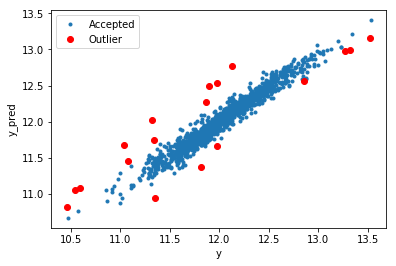

In [0]:
outliers = find_outliers(Ridge(), train, y_train)

In [0]:
X = train.drop(outliers)
y = y_train.drop(outliers)

#Modeling

In [0]:
from sklearn.model_selection import GridSearchCV, RepeatedKFold, cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from mlxtend.regressor import StackingCVRegressor

In [0]:
def train_model(model,X,y,param_grid=[], splits = 5, repeats=5):
  rkfold = RepeatedKFold(n_splits=splits, n_repeats=repeats,random_state=42)
  gsearch = GridSearchCV(model, param_grid, cv=rkfold,
                                 scoring=rmse_scorer,
                                 verbose=1, return_train_score=True)
  gsearch.fit(X,y)
  model = gsearch.best_estimator_
  best_idx = gsearch.best_index_
    
  grid_results = pd.DataFrame(gsearch.cv_results_)       
  cv_mean = abs(grid_results.loc[best_idx,'mean_test_score'])
  cv_std = grid_results.loc[best_idx,'std_test_score']
  y_pred = model.predict(X)
  print('----------------------')
  print(model)
  print('----------------------')
  print('best params: ',gsearch.best_params_)
  print('----------------------')
  print('cross_val: mean=',cv_mean,', std=',cv_std)
  return model

## Models

**Base models**

In [0]:
# alph_range = np.arange(0.25,6,0.25)
# param_grid = {'alpha': alph_range}
# model = train_model(Ridge(),X,y,param_grid=param_grid)
ridge = make_pipeline(RobustScaler(),Ridge(alpha = 2.0))

In [0]:
# alph_range = np.arange(1e-4,1e-3,4e-5)
# param_grid = {'alpha': alph_range}
# model = train_model(Lasso(),X,y,param_grid=param_grid)
lasso = make_pipeline(RobustScaler(),Lasso(alpha = 0.00022))

In [0]:
# param_grid = {'alpha': np.arange(1e-4,1e-3,1e-4),
#               'l1_ratio': np.arange(0.1,1.0,0.1),
#               'max_iter':[100000]}
# model = train_model(ElasticNet(),X,y,param_grid=param_grid)
# elastic = model
elastic = make_pipeline(RobustScaler(),ElasticNet(alpha = 0.0004,l1_ratio = 0.5,max_iter = 100000))

In [0]:
# param_grid = {
#  'n_estimators':[200,500,1000,2000,5000]
# }
# model = train_model(xgb.XGBRegressor(max_depth = 8,min_child_weight = 6,gamma = 0.0,
#                                      colsample_bytree= 0.95,subsample=0.6,reg_alpha = 0.01,
#                                      learning_rate = 0.01,n_estimators = 2000,
#                                      nthread=4, scale_pos_weight=1,random_state=27),X,y,param_grid=param_grid)
xgr = XGBRegressor(max_depth = 3,min_child_weight = 2,gamma = 0.0,
                       colsample_bytree= 0.7,subsample=0.7,reg_alpha = 0.01,
                       learning_rate = 0.01,n_estimators = 5000,
                       nthread=4, scale_pos_weight=1,random_state=27)

In [0]:
lightgbm = LGBMRegressor(objective='regression', 
                                       num_leaves=4,
                                       learning_rate=0.01, 
                                       n_estimators=5000,
                                       max_bin=200, 
                                       bagging_fraction=0.75,
                                       bagging_freq=5, 
                                       bagging_seed=7,
                                       feature_fraction=0.2,
                                       feature_fraction_seed=7,
                                       verbose=-1,
                                       )

**Stack model**

In [0]:
stack_gen = StackingCVRegressor(regressors=(ridge, lasso, elastic, xgr,lightgbm),
                                meta_regressor=ridge,
                                use_features_in_secondary=True,)

##Models Scores

In [0]:
lightgbm.fit(X,y)
lightgbm_train = lightgbm.predict(X)
lightgbm_test = np.expm1(lightgbm.predict(test))
print('Lightgbm score: ',rmse(y, lightgbm_train))

Lightgbm score:  0.06449168750285451


In [0]:
lasso.fit(X,y)
lasso_train = lasso.predict(X)
lasso_test = np.expm1(lasso.predict(test))
print('Lasso score: ',rmse(y, lasso_train))

Lasso score:  0.0830859715280923


In [0]:
xgr.fit(X,y)
xgr_train = xgr.predict(X)
xgr_test = np.expm1(xgr.predict(test))
print('Xgboost score: ',rmse(y, xgr_train))

/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[09:43:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Xgboost score:  0.03421418294838415


In [0]:
ridge.fit(X,y)
ridge_train = ridge.predict(X)
ridge_test = np.expm1(ridge.predict(test))
print('Ridge score: ',rmse(y, ridge_train))

Ridge score:  0.0803930983483051


In [0]:
elastic.fit(X,y)
elastic_train = elastic.predict(X)
elastic_test = np.expm1(elastic.predict(test))
print('ElasticNet score: ',rmse(y, elastic_train))

ElasticNet score:  0.08286861623308642


In [0]:
stack_gen.fit(np.array(X), np.array(y))
stack_gen_train = stack_gen.predict(np.array(X))
stack_gen_test = np.expm1(stack_gen.predict(np.array(test)))
print('Stack model score: ',rmse(y, stack_gen_train))

[09:44:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:44:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:45:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:45:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:46:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:47:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Stack model score:  0.07187826305757736


## Blending models

In [0]:
train_predict = 0.1*ridge_train+0.1*lasso_train+0.1*elastic_train+0.2*xgr_train+0.2*lightgbm_train+0.3*stack_gen_train
print('RMSE score on train data:')
print(rmse(y,train_predict))

RMSE score on train data:
0.06339436873895912


In [0]:
blend = (0.1*ridge_test+0.1*lasso_test+0.1*elastic_test+0.2*xgr_test+0.2*lightgbm_test+0.3*stack_gen_test)


##Brutal Force And Save Submission File

In [0]:
sub = pd.DataFrame()
sub['Id'] = test_ID
sub['SalePrice'] = blend
q1 = sub['SalePrice'].quantile(0.0042)
q2 = sub['SalePrice'].quantile(0.99)

sub['SalePrice'] = sub['SalePrice'].apply(lambda x: x if x > q1 else x*0.9)
sub['SalePrice'] = sub['SalePrice'].apply(lambda x: x if x < q2 else x*1.07)

sub.to_csv('submission.csv',index=False)